In [2]:
from dataclasses import dataclass

import ipywidgets
import matplotlib.pyplot as plt

import pandas as pd
from IPython.display import display
from ipywidgets import Dropdown, HBox, Output, ToggleButton, VBox

pd.options.mode.chained_assignment = None

# %matplotlib inline

def load_speech_index(index_path: str, members_path: str) -> pd.DataFrame:
    """Load speech index. Merge with person index (parla. members, ministers, speakers)"""
    speech_index: pd.DataFrame = pd.read_feather(index_path)
#     members: pd.DataFrame = pd.read_csv(members_path)
    members: pd.DataFrame = pd.read_csv(members_path,delimiter='\t').set_index('id')
    speech_index['protocol_name'] = speech_index.filename.str.split('_').str[0]
    speech_index = speech_index.merge(members, left_on='who', right_index=True, how='inner').fillna('')
    speech_index.loc[speech_index['gender']=='','gender'] = 'unknown'
    return speech_index, members

def plot_pivot(data: pd.DataFrame, kind: str):
    if kind == 'table':
        display(data.round(2))
    elif kind == 'excel':
        display(data.round(2))
        data.to_excel('output.xlsx')
        print('Saved as output.xlsx')
    else:
        data.plot(kind=kind, figsize=(20,10))
        plt.show()

def compute_statistics(
    *, temporal_key: str, pivot_key: str, pivot_sub_key: str, pivot_value: str, normalize: bool, mode: str
):
    
    data: pd.DataFrame = SPEECH_INDEX.copy()

    if pivot_value:
        data = data[data[pivot_key] == pivot_value]
        pivot_key = pivot_sub_key

    if temporal_key == 'decade':
        data[temporal_key] = data.year - data.year % 10
    
    pivot: pd.DataFrame = None

    if mode == 'token':
        pivot = data.groupby([temporal_key, pivot_key]).agg({'n_tokens': sum}).unstack(level=1)
    elif mode == 'speech':
        pivot = pd.DataFrame(data.groupby([temporal_key, pivot_key]).size()).unstack(level=1)
    elif mode == 'speaker':
        pivot = data.groupby([temporal_key, pivot_key]).agg({'who': lambda x: len(set(x))}).unstack(level=1)
    pivot = pivot.fillna(0)
    

    if normalize:
        pivot = pivot.div(pivot.sum(axis=1), axis=0)
    if hasattr (pivot.columns,'levels'):        
        pivot.columns = pivot.columns.levels[1].tolist()

    return pivot

@dataclass
class CaseOneGUI:

    pivot_key: str = None
    pivot_sub_key: str = None
    pivot_values = Dropdown(description='Pivot', options=[], layout={'width': '160px'})
    mode = Dropdown(description='Mode', options=['token', 'speech', 'speaker'], value='token', layout={'width': '160px'})
    period = Dropdown(description='Period', options=['year', 'decade'], value='decade', layout={'width': '160px'})
    kind = Dropdown(description='Kind', options=['area', 'line', 'bar', 'table','excel'], value='table', layout={'width': '160px'})
    normalize = ToggleButton(description='Normalize', value=True, layout={'width': '160px'})
    output = Output()

    def layout(self):
        return VBox([
            HBox([
                VBox([self.pivot_values, self.period]),
                VBox([self.kind, self.mode]),
                self.normalize
            ]),
            self.output
        ])

    def setup(self, pivot_values) -> "CaseOneGUI":
        self.pivot_values.options = pivot_values
        self.pivot_values.observe(self.handler, 'value')
        self.mode.observe(self.handler, 'value')
        self.period.observe(self.handler, 'value')
        self.kind.observe(self.handler, 'value')
        self.normalize.observe(self.handler, 'value')
        return self

    def update(self):

        opts: dict = dict(
            temporal_key=self.period.value,
            pivot_key=self.pivot_key,
            pivot_sub_key=self.pivot_sub_key,
            pivot_value=self.pivot_values.value,
            normalize=self.normalize.value,
            mode=self.mode.value,
        )

        self.output.clear_output()
        with self.output:
            # print(opts)
            data: pd.DataFrame = compute_statistics(**opts)
            plot_pivot(data, kind=self.kind.value)

    def handler(self, *_):
        self.update()


SPEECH_INDEX, MEMBERS = load_speech_index(
    '/data/riksdagen_corpus_data/tagged-speech-corpus.v0.3.0.id.lemma.no-stopwords.lowercase.feather/document_index.feather',
    '/data/riksdagen_corpus_data/tagged-speech-corpus.v0.3.0.id.lemma.no-stopwords.lowercase.feather/person_index.csv'
)

PARTYS = SPEECH_INDEX.party_abbrev.unique().tolist()
GENDERS = SPEECH_INDEX.gender.unique().tolist()

In [38]:
# MEMBERS =  pd.read_csv('person_index.csv',delimiter='\t').set_index('id')
SPEECH_INDEX.party_abbrev.value_counts()

S      144303
gov    116568
M      111530
L       71687
C       63389
V       49635
MP      24450
KD      21897
        11540
SD       8565
NYD      1981
Name: party_abbrev, dtype: int64

## Words/speeches per party over time
 - Ministers are encoded as party `gov` and gender `unknown`
 - Mode: `token` number of tokens, `speech` number of speeches, `speaker`number of unique speakers

In [3]:
guip = CaseOneGUI(pivot_key='party_abbrev', pivot_sub_key='gender')\
    .setup(pivot_values=[''] + PARTYS)
display(guip.layout())
guip.update()

## Words/speeches per gender over time

In [4]:
guig = CaseOneGUI(pivot_key='gender')\
    .setup(pivot_values=[''] + GENDERS)
display(guig.layout())
guig.update()

## Words per speech over time


NOTE 1995 REMOVED


<AxesSubplot:xlabel='year'>

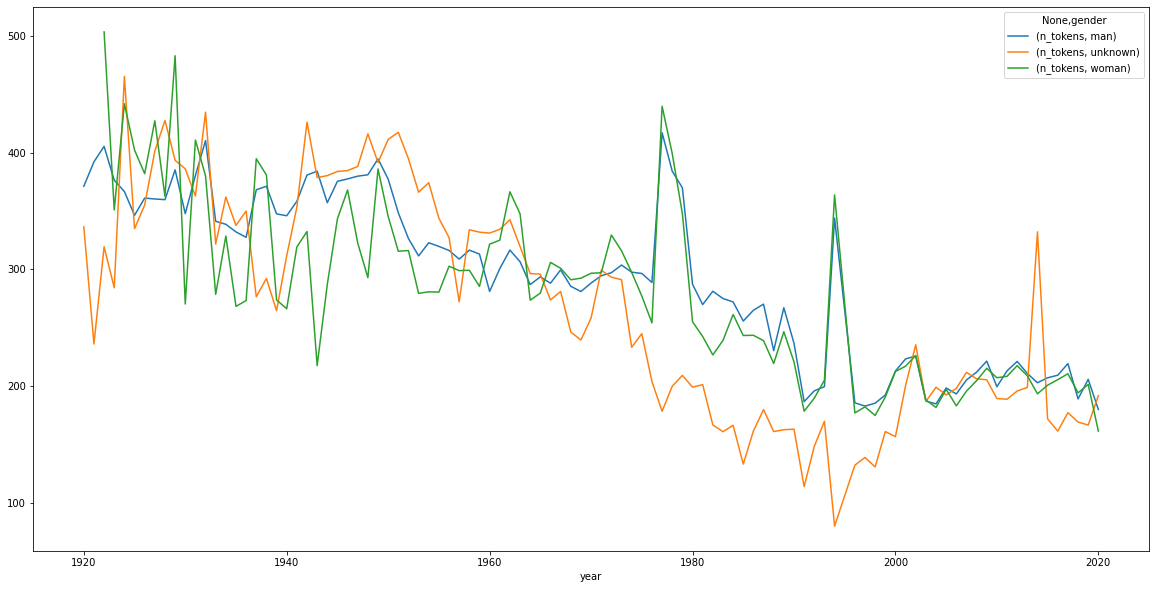

In [16]:
pd.set_option('display.max_rows', 1000)
print('NOTE 1995 REMOVED')
SPEECH_INDEX[SPEECH_INDEX.year != 1995].groupby(['year', 'gender']).agg({'n_tokens': lambda x: sum(x)/len(x)}).unstack(level=1).plot(figsize=(20,10))

# Additional quality metrics

<AxesSubplot:>

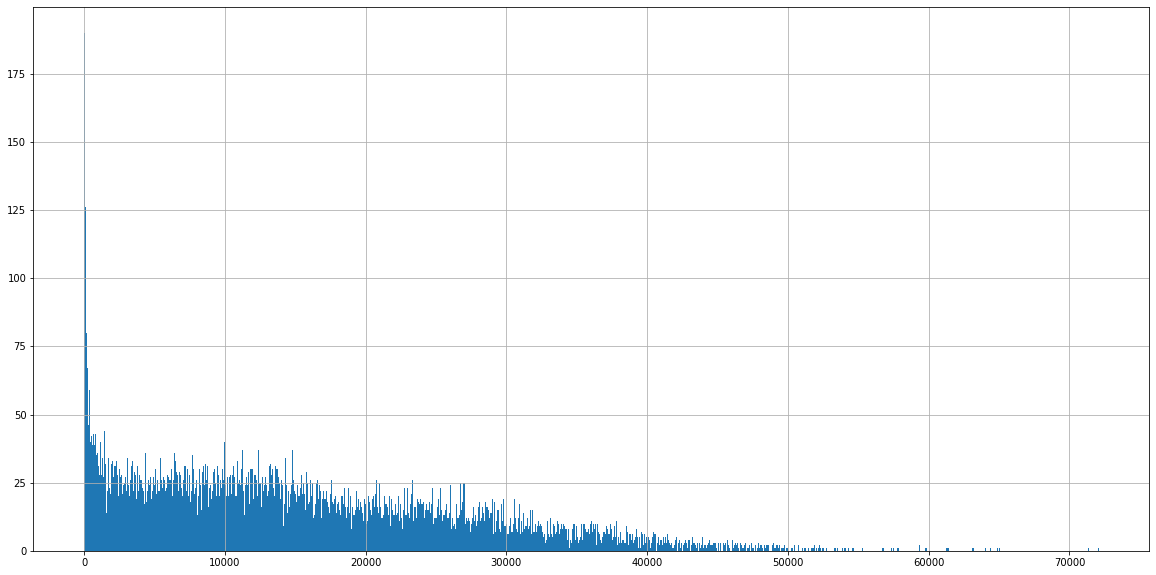

In [12]:
SPEECH_INDEX.groupby(['protocol_name'])['n_tokens'].sum().hist(bins=1000,figsize=(20,10))

In [7]:
SPEECH_INDEX[SPEECH_INDEX.year != 1995].columns

Index(['year', 'document_name', 'filename', 'n_tokens', 'who', 'document_id',
       'protocol_name', 'role_type', 'born', 'chamber', 'district', 'start',
       'end', 'gender', 'name', 'occupation', 'party', 'party_abbrev'],
      dtype='object')

Index(['role_type', 'born', 'chamber', 'district', 'start', 'end', 'gender',
       'name', 'occupation', 'party', 'party_abbrev'],
      dtype='object')


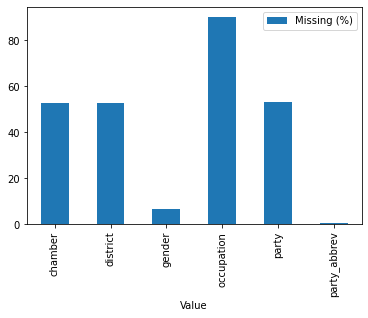

In [8]:
# from math import round
print(MEMBERS.columns)
# SPEECH_INDEX[SPEECH_INDEX.born != ''].groupby(['born']).size().plot() # TODO FIXA GENOMSNITTSÅLDER
# SPEECH_INDEX.groupby(['year','party_abbrev']).agg({'born': lambda x: next((z for z in x if z != ''),-1)})

def count_empty(x):
    return (x.isna() | x.isnull() | x.eq('') | x.eq('unknown')).sum()

l = list()

for col in MEMBERS.columns:
#     print(f"Members without {col} specified: {round((MEMBERS[col].isna().sum()) / len(MEMBERS['born']),4)*100}%")
    empty_percentage = round(count_empty(MEMBERS[col]) / len(MEMBERS['born'])*100,3)
    if empty_percentage > 0:
         l.append((col,empty_percentage))
#         print(f"Members without {col} specified: {empty_percentage}%")
pd.DataFrame(l,columns=['Value','Missing (%)']).set_index('Value').plot.bar();

In [17]:
MEMBERS.groupby(['occupation']).size().sort_values(ascending=False).head(30)
# MEMBERS

occupation
ombudsman            207
lantbrukare          188
statsråd              80
f.d. statsråd         74
fru                   67
redaktör              58
metallarbetare        49
rektor                48
sekreterare           42
direktör              42
civilekonom           37
socionom              34
politiker             33
kommunalråd           22
verkmästare           20
adjunkt               20
folkskollärare        18
arbetsförmedlare      17
avdelningschef        17
hemmansägare          17
elektriker            16
ämneslärare           16
studieombudsman       16
lärare                15
ingenjör              15
järnbruksarbetare     15
lågstadielärare       14
sjuksköterska         14
fabrikör              14
kontorist             14
dtype: int64

<AxesSubplot:>

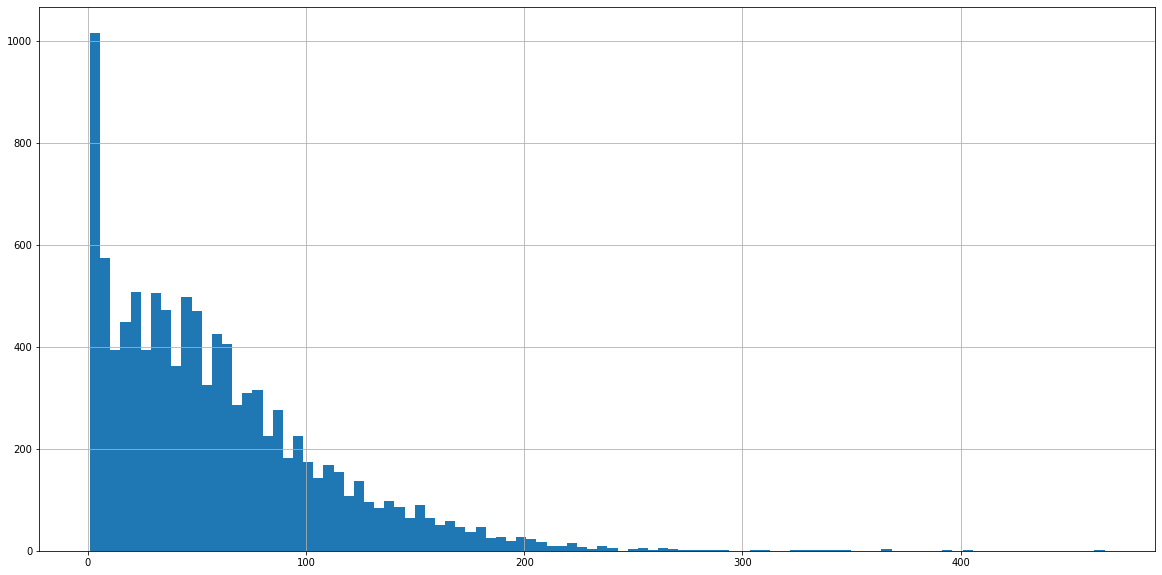

In [18]:
SPEECH_INDEX.groupby(['protocol_name']).size().hist(bins=100,figsize=(20,10))

In [22]:
print(SPEECH_INDEX.columns)
SPEECH_INDEX.head(10)

Index(['year', 'document_name', 'filename', 'n_tokens', 'who', 'document_id',
       'protocol_name', 'role_type', 'born', 'chamber', 'district', 'start',
       'end', 'gender', 'name', 'occupation', 'party', 'party_abbrev'],
      dtype='object')


,year,document_name,filename,n_tokens,who,document_id,protocol_name,role_type,born,chamber,district,start,end,gender,name,occupation,party,party_abbrev
0,1920,prot-1920--ak--10_001,prot-1920--ak--10_001.csv,595,ivar_teodor_vennerstrom_b5455a,0,prot-1920--ak--10,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
77,1920,prot-1920--ak--17_028,prot-1920--ak--17_028.csv,793,ivar_teodor_vennerstrom_b5455a,77,prot-1920--ak--17,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
83,1920,prot-1920--ak--18_002,prot-1920--ak--18_002.csv,1786,ivar_teodor_vennerstrom_b5455a,83,prot-1920--ak--18,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
203,1920,prot-1920--ak--23_008,prot-1920--ak--23_008.csv,2495,ivar_teodor_vennerstrom_b5455a,203,prot-1920--ak--23,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
252,1920,prot-1920--ak--25_032,prot-1920--ak--25_032.csv,366,ivar_teodor_vennerstrom_b5455a,252,prot-1920--ak--25,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
585,1920,prot-1920--ak--35_017,prot-1920--ak--35_017.csv,160,ivar_teodor_vennerstrom_b5455a,585,prot-1920--ak--35,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
587,1920,prot-1920--ak--35_019,prot-1920--ak--35_019.csv,60,ivar_teodor_vennerstrom_b5455a,587,prot-1920--ak--35,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
614,1920,prot-1920--ak--38_004,prot-1920--ak--38_004.csv,157,ivar_teodor_vennerstrom_b5455a,614,prot-1920--ak--38,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
621,1920,prot-1920--ak--38_011,prot-1920--ak--38_011.csv,221,ivar_teodor_vennerstrom_b5455a,621,prot-1920--ak--38,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov
625,1920,prot-1920--ak--38_015,prot-1920--ak--38_015.csv,333,ivar_teodor_vennerstrom_b5455a,625,prot-1920--ak--38,member,0,,,1920,1920,man,Ivar Teodor Vennerström,,unknown,gov


In [ ]:
SPEECH_INDEX.groupby(['protocol_name']).size().hist(bins=100,figsize=(20,10))

# Statistik

1. Procentuell bar eller area. Normalisera efter antal ledamöter?
2. Män och kvinnor (samma bild som ovan)
3. Snitt längd av tal pedatar år, kön?


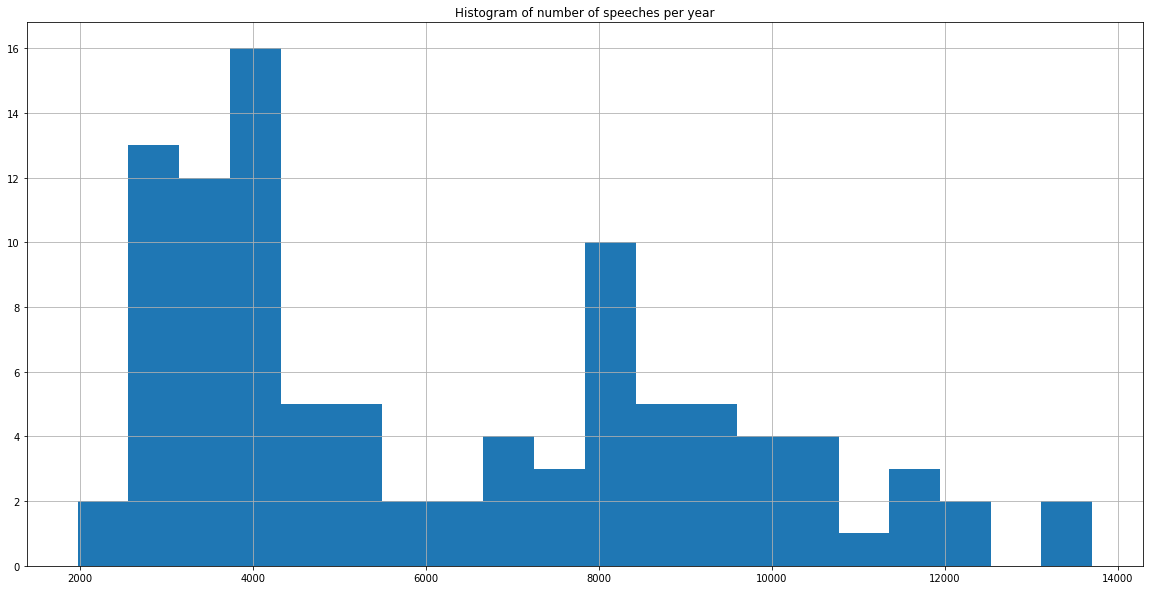

In [28]:
year_group = SPEECH_INDEX[SPEECH_INDEX.year != 1995].drop(columns='document_id').groupby('year')

ax = year_group.size().hist(bins=20,figsize=(20,10));
ax.set_title('Histogram of number of speeches per year');

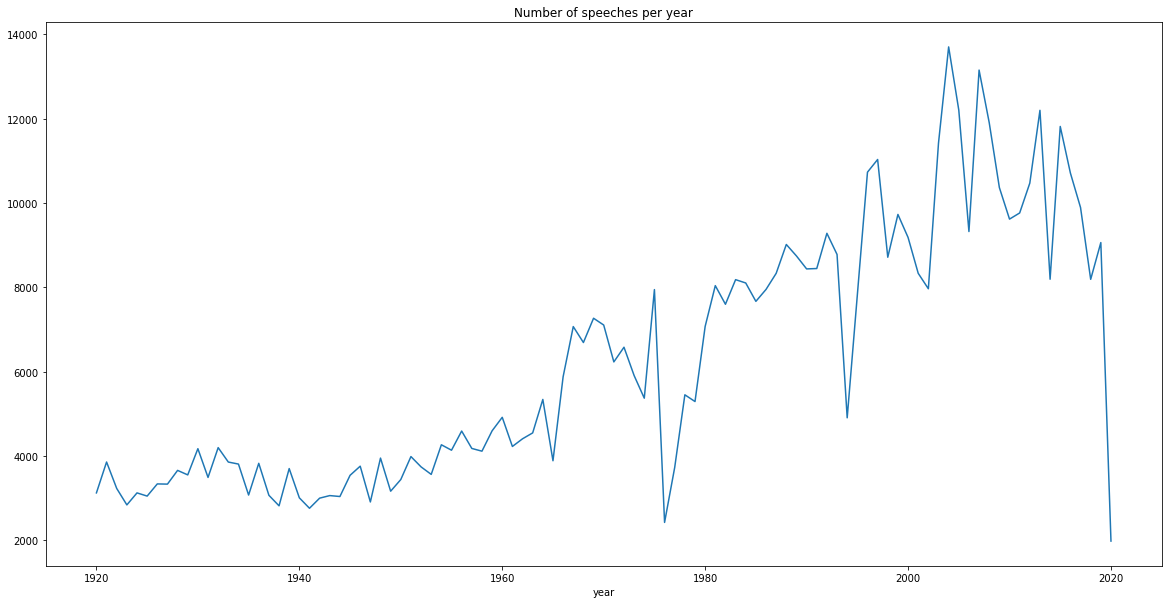

In [27]:
year_group.size().plot(figsize=(20,10),title='Number of speeches per year');

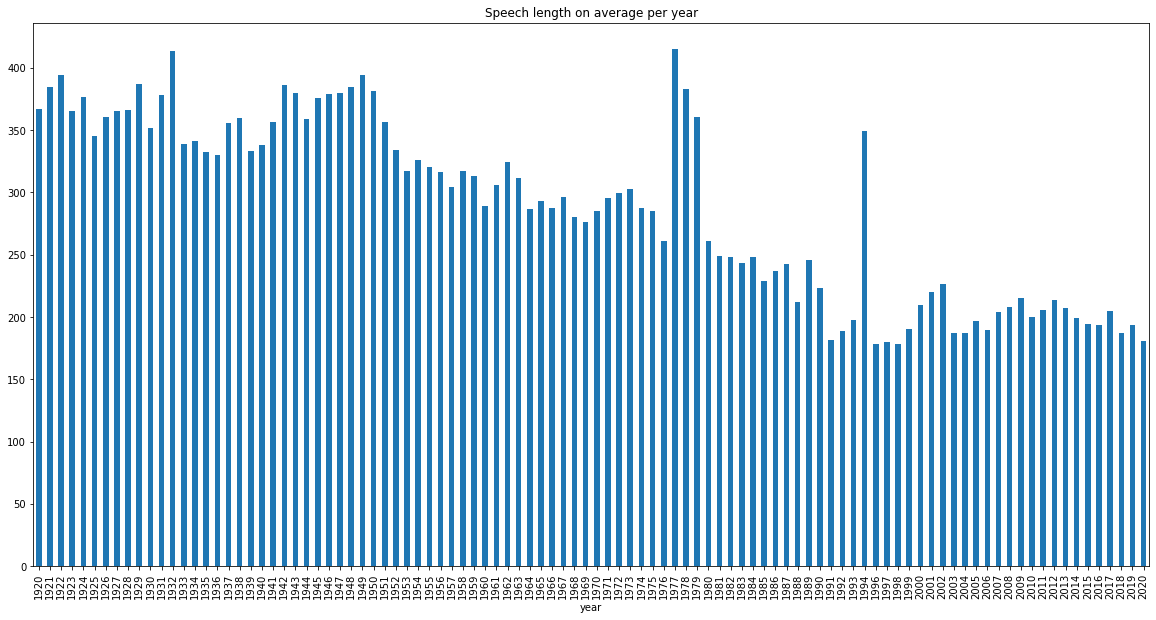

In [29]:
year_group['n_tokens'].sum().div(year_group.size()).plot.bar(figsize=(20,10),title='Speech length on average per year',rot=90);

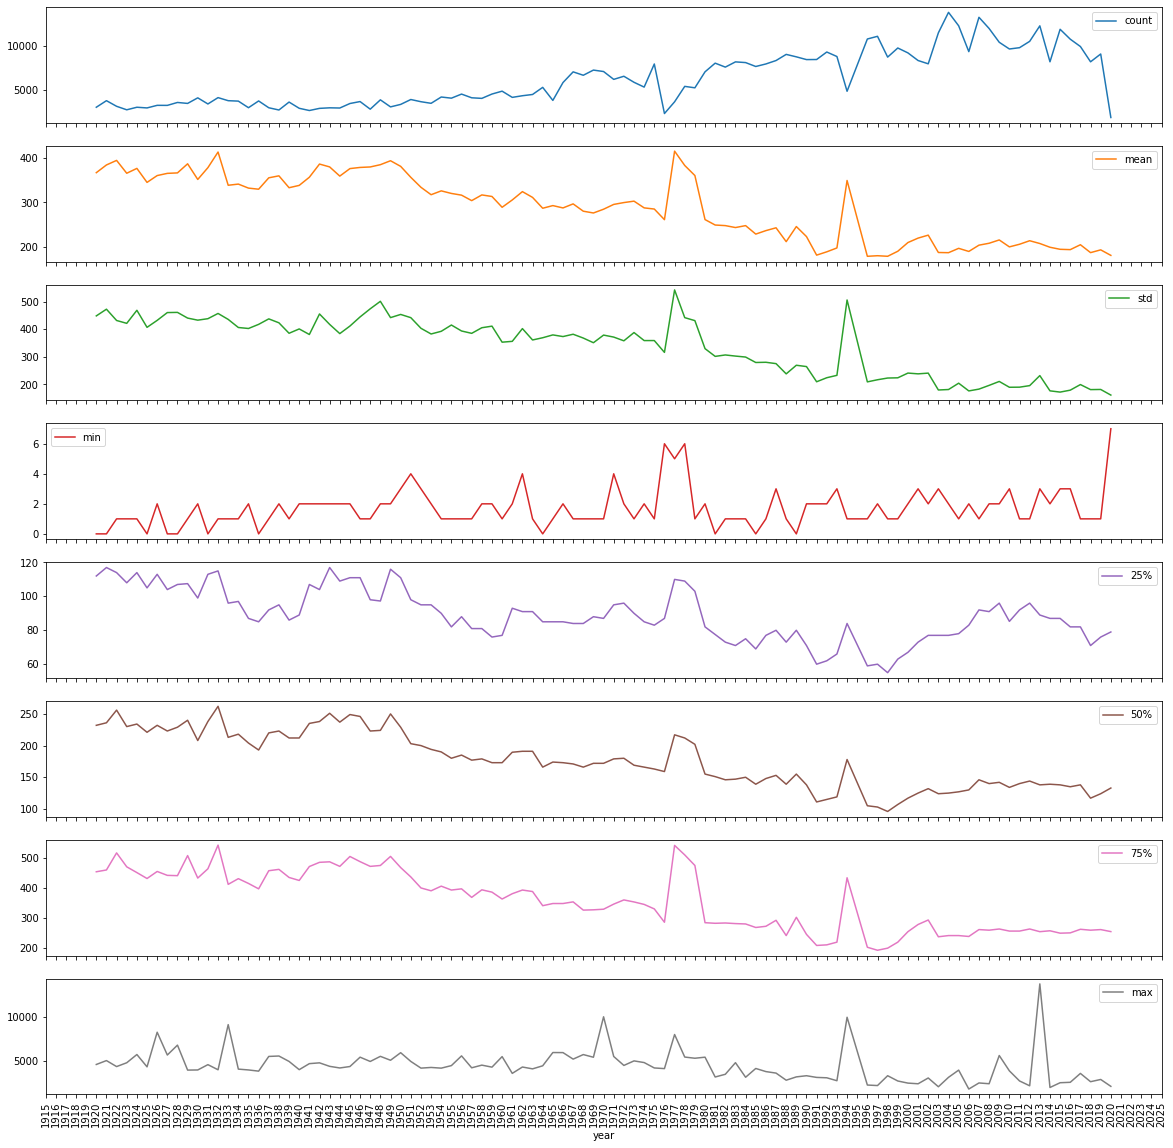

In [30]:
import matplotlib.ticker as ticker
axes = year_group['n_tokens'].describe().plot(subplots=True, figsize=(20,20),rot=90);

for ax in axes:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

In [31]:
SPEECH_INDEX.columns

Index(['year', 'document_name', 'filename', 'n_tokens', 'who', 'document_id',
       'protocol_name', 'role_type', 'born', 'chamber', 'district', 'start',
       'end', 'gender', 'name', 'occupation', 'party', 'party_abbrev'],
      dtype='object')

In [32]:
year_party = SPEECH_INDEX[SPEECH_INDEX.year != 1995].drop(columns=['document_id']).groupby(['year', 'party_abbrev'])
year_party.describe()

n_tokens                                                  \
                     count         mean          std    min     25%    50%   
year party_abbrev                                                            
1920                 155.0   202.187097   210.810427    5.0   56.00  143.0   
     C                50.0   307.340000   376.679890    4.0   48.00  174.5   
     L                53.0   344.962264   419.606361   19.0  112.00  238.0   
     M               492.0   331.404472   371.906281    6.0  114.00  207.0   
     S               356.0   345.707865   335.196665    5.0  121.75  247.0   
     gov            2014.0   394.203078   493.672213    0.0  117.00  243.0   
1921                 141.0   186.581560   222.839473    4.0   46.00  114.0   
     C                41.0   329.926829   291.715220   10.0  113.00  274.0   
     L               467.0   397.736617   515.682332    6.0  128.00  242.0   
     M               872.0   374.030963   478.944443    0.0  118.00  217.5   
     S              1091.0   388.386801   478.660255    4.0  115.00  239.0   
     gov            1241.0   407.382756   467.967339    0.0  128.00  251.0   
1922                 114.0   225.657895   314.426429    7.0   58.25  140.0   
     C                82.0   394.268293   346.963977   18.0  149.75  255.0   
     L               113.0   537.663717   552.912945    7.0  188.00  384.0   
     M               599.0   390.883139   405.906026    6.0  117.00  259.0   
     S               861.0   364.466899   376.436931    1.0  118.00  245.0   
     gov            1456.0   416.155220   468.496615    2.0  111.50  272.5   
1923                  96.0   233.041667   308.834342    9.0   45.75  109.5   
     C               117.0   348.769231   312.051123    9.0  103.00  259.0   
     L                92.0   482.815217   527.333098    5.0  148.00  298.5   
     M               579.0   346.340242   367.459119    1.0  116.00  228.0   
     S               764.0   371.863874   386.148553    2.0  128.00  248.0   
     gov            1187.0   374.508003   471.116286    2.0   99.00  224.0   
1924                  49.0   266.204082   259.019142    7.0   67.00  171.0   
     C                95.0   375.747368   311.359783   13.0  161.50  301.0   
     L                81.0   468.790123   512.607933   10.0  165.00  273.0   
     M               614.0   335.486971   388.387900    7.0  117.00  216.5   
     S               939.0   367.507987   456.690452    7.0  118.00  246.0   
     gov            1342.0   400.426230   519.246145    1.0  106.00  226.5   
1925                 112.0   229.982143   282.611597   10.0   64.25  150.5   
     C               117.0   355.820513   311.107521    6.0  131.00  247.0   
     L               283.0   341.173145   379.206116    6.0  110.00  240.0   
     M               678.0   371.824484   435.772501    7.0  119.00  230.0   
     S               773.0   301.490298   307.520978    0.0  106.00  211.0   
     gov            1081.0   371.362627   469.738873    2.0   94.00  229.0   
1926                 121.0   215.925620   514.790883    2.0   45.00   96.0   
     C               156.0   324.429487   307.088873    6.0  126.50  229.0   
     L               261.0   351.885057   342.180949   11.0  146.00  245.0   
     M               822.0   364.149635   387.058070    8.0  113.00  237.5   
     S               938.0   355.164179   371.663337    2.0  123.25  239.5   
     gov            1035.0   386.901449   530.065205    2.0  109.00  236.0   
1927                  97.0   162.484536   173.420378    8.0   46.00  102.0   
     C               194.0   332.582474   394.712023    5.0  109.25  216.0   
     L               184.0   288.625000   266.794769    6.0  103.50  200.0   
     M               745.0   373.853691   458.791937    0.0  110.00  235.0   
     S              1193.0   382.164292   493.583680    5.0  115.00  230.0   
     gov             915.0   380.742077   476.501679    1.0   97.50  227.0   
1928                  91.0   235.736264 